<a href="https://colab.research.google.com/github/francuzovd/project_classification/blob/master/Project_FrantsuzovDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Импорт и функции**

In [0]:
!pip install catboost

In [0]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [0]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [0]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [0]:
def info_table(df):
  feautures = df.columns
  null_data = df.isnull().sum()
  types_data = df.dtypes
  unique_data = pd.Series(data = [len(df[x].unique()) for x in df.columns],
                          index = feautures)

  info_table = pd.DataFrame(np.array([feautures, null_data, types_data, unique_data]).T, 
                            columns=['Features', 'Null', 'Type', 'Unique'])
  
  return info_table

In [0]:
def research_feature(feature):
  d = df.pivot_table(values='ID', index=feature, columns=TARGET, aggfunc='count').reset_index()
  d['Mean 1'] = d[1] / (d[1] + d[0])

  print(d)
  f, ax = plt.subplots(figsize=(20, 6))
  sns.countplot(y=feature, hue=TARGET, data=df)
  plt.show()

In [0]:
def stat_p(col, data):
  home_owner = df.loc[df[col].isin(data)].sample(1000)
  table = home_owner.pivot_table(values='ID', index=col, columns=TARGET, aggfunc='count')
  print(table)
  chi2, p, dof, expected = chi2_contingency(table, correction=False)
  return p

In [0]:
def create_new_feature(model, new_col, old_col, dict_replace):
  model[new_col] = model.replace(dict_replace)[old_col]
  return model

In [0]:
def find_parametrs(name, model, params):
  cv=KFold(n_splits=3, random_state=21, shuffle=True)
#   %%time

  rs = RandomizedSearchCV(model, params, scoring='f1', cv=cv, n_jobs=-1, return_train_score=True)
  rs.fit(X_train, y_train)
  print(f'{name}: max score - {rs.best_score_}, best parametrs - {rs.best_params_}')

## **Изучение данных**

### **Загрузка данных**

In [0]:
PATH = '/content/drive/My Drive/GeekBrains/Python для Data Science 2/Курсовая'

In [0]:
df = pd.read_csv(PATH + '/course_project_train.csv')
df_valid = pd.read_csv(PATH + '/course_project_test.csv')

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [0]:
df_valid.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


### **Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### **Добавление поля ID**

In [0]:
df['ID'] = np.arange(0, df.shape[0])
df.shape

(7500, 18)

In [0]:
df_valid['ID'] = np.arange(7500, 7500 + df_valid.shape[0])
df_valid.shape

(2500, 17)

In [0]:
df_start_test = df.copy()
df_start_valid = df_valid.copy()
frames = [df, df_valid]

In [0]:
for frame in frames:
  print(frame.columns)

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'ID'],
      dtype='object')
Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'ID'],
      dtype='object')


## **Исследование данных**

### **Целевая переменная**

In [0]:
TARGET = 'Credit Default'
df[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### **Проверка типов данных и иих изменение**

In [0]:
df_info = info_table(df)
df_info

,Features,Null,Type,Unique
0,Home Ownership,0,object,4
1,Annual Income,1557,float64,5479
2,Years in current job,371,object,12
3,Tax Liens,0,float64,8
4,Number of Open Accounts,0,float64,39
5,Years of Credit History,0,float64,408
6,Maximum Open Credit,0,float64,6963
7,Number of Credit Problems,0,float64,8
8,Months since last delinquent,4081,float64,90
9,Bankruptcies,14,float64,6


In [0]:
info_table(df_valid)

,Features,Null,Type,Unique
0,Home Ownership,0,object,4
1,Annual Income,513,float64,1930
2,Years in current job,86,object,12
3,Tax Liens,0,float64,8
4,Number of Open Accounts,0,float64,35
5,Years of Credit History,0,float64,345
6,Maximum Open Credit,0,float64,2435
7,Number of Credit Problems,0,float64,8
8,Months since last delinquent,1358,float64,84
9,Bankruptcies,3,float64,7


### Категориальные признаки

In [0]:
OBJECT_COLS = df_info.loc[df_info['Unique'] <= 15, 'Features'][:-1].to_list()

In [0]:
for frame in frames:
  for col in OBJECT_COLS:
    frame[col] = frame[col].astype(str)

In [0]:
df_info = info_table(df)
df_info

,Features,Null,Type,Unique
0,Home Ownership,0,object,4
1,Annual Income,1557,float64,5479
2,Years in current job,0,object,12
3,Tax Liens,0,object,8
4,Number of Open Accounts,0,float64,39
5,Years of Credit History,0,float64,408
6,Maximum Open Credit,0,float64,6963
7,Number of Credit Problems,0,object,8
8,Months since last delinquent,4081,float64,90
9,Bankruptcies,0,object,6


In [0]:
info_table(df_valid)

,Features,Null,Type,Unique
0,Home Ownership,0,object,4
1,Annual Income,513,float64,1930
2,Years in current job,0,object,12
3,Tax Liens,0,object,8
4,Number of Open Accounts,0,float64,35
5,Years of Credit History,0,float64,345
6,Maximum Open Credit,0,float64,2435
7,Number of Credit Problems,0,object,8
8,Months since last delinquent,1358,float64,84
9,Bankruptcies,0,object,7


In [0]:
# for col in OBJECT_COLS:
#   print(f'{col}\n{df[col].value_counts()}')
#   f, ax = plt.subplots(figsize=(15, 6))
#   sns.countplot(y=col, hue=TARGET, data=df)
#   plt.show()
#   print('-' * 50, '\n')

**Вывод**

* *Home Ownership*: надо исследовать Have Mortage, на графике плохо видно распределение данных.
* *Years in current job*: слишком много данных, проверить возможность объединения данных.
* *Tax Liens*: больше всего данных находится в значении 0.0, изучить другие данные и принять решение об объединении или удалении.
* *Number of Credit Problems*: больше всего данных находится в значении 0 и 1, изучить другие данные и принять решение об объединении или удалении.
Визуально Tax Liens и Number of Credit Problems в значении 0 похожи.
* *Bankruptcies*: больше всего данных находится в значении 0 и 1, изучить другие данные и принять решение об объединении или удалении.
* *Purpose*: очень много категорий, пожумать об уменьшении количеста. Отдельно исследовать без debt consolidation.
* *Term*: оставить без изменений.

#### Home ownership



Credit Default Home Ownership     0     1    Mean 1
0               Have Mortgage    10     2  0.166667
1               Home Mortgage  2721   916  0.251856
2                    Own Home   455   192  0.296754
3                        Rent  2201  1003  0.313046


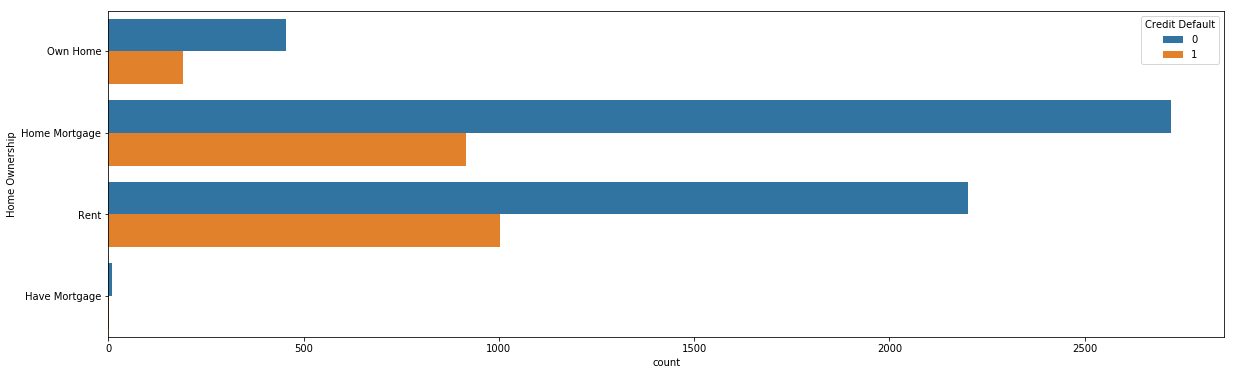

In [0]:
research_feature('Home Ownership')

Частота Own Home и Rent схожи. проведём исследование

In [0]:
stat_p('Home Ownership', ['Own Home', 'Rent'])

Credit Default    0    1
Home Ownership          
Own Home        120   49
Rent            570  261


0.5362357205035012

Исследование по методу Фишера

In [0]:
home_owner = df.loc[df['Home Ownership'].isin(['Have Mortgage', 'Home Mortgage'])]
table = home_owner.pivot_table(values='ID', index='Home Ownership', columns=TARGET, aggfunc='count')
print(table)
odd, p = fisher_exact(table)
p

Credit Default     0    1
Home Ownership           
Have Mortgage     10    2
Home Mortgage   2721  916


0.7414933535927103

In [0]:
NEW_FEATURES = []

In [0]:
old_col = 'Home Ownership'
new_col = 'Credit ownership'
dict_replace = dict(zip(['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], [1, 1, 0, 0]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 1]
[0 1]


#### Years in current job

Credit Default Years in current job     0    1    Mean 1
0                            1 year   362  142  0.281746
1                         10+ years  1688  644  0.276158
2                           2 years   512  193  0.273759
3                           3 years   450  170  0.274194
4                           4 years   338  131  0.279318
5                           5 years   371  145  0.281008
6                           6 years   302  124  0.291080
7                           7 years   285  111  0.280303
8                           8 years   247   92  0.271386
9                           9 years   194   65  0.250965
10                         < 1 year   404  159  0.282416
11                              nan   234  137  0.369272


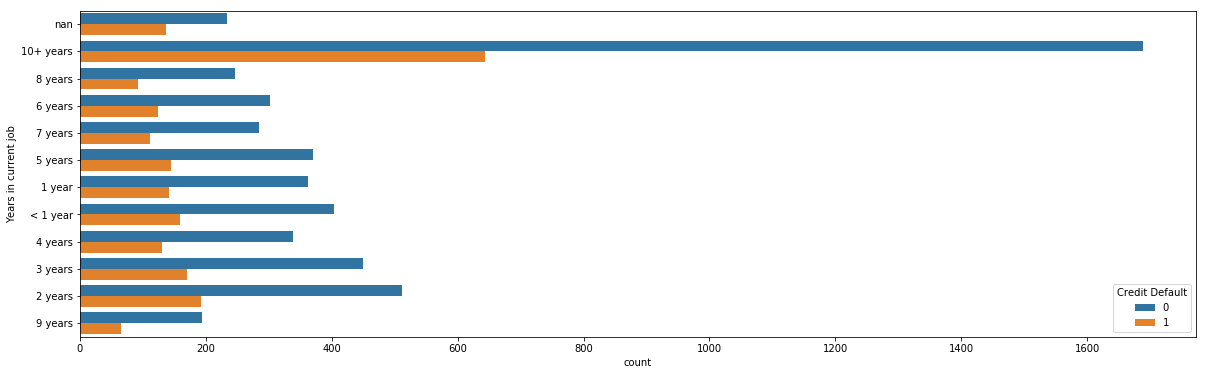

In [0]:
research_feature('Years in current job')

In [0]:
old_col = 'Years in current job'
new_col = 'Years job experiance'
dict_replace = dict(zip(['nan', '10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'], [0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 2 1]
[1 2 0]


#### **Tax Liens**

Credit Default Tax Liens       0       1    Mean 1
0                    0.0  5301.0  2065.0  0.280342
1                    1.0    59.0    24.0  0.289157
2                    2.0    15.0    15.0  0.500000
3                    3.0     5.0     5.0  0.500000
4                    4.0     3.0     3.0  0.500000
5                    5.0     1.0     1.0  0.500000
6                    6.0     2.0     NaN       NaN
7                    7.0     1.0     NaN       NaN


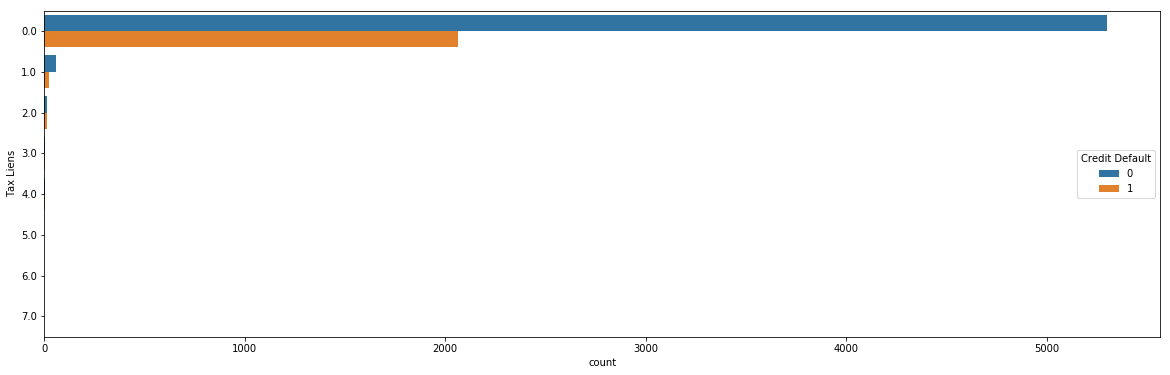

In [0]:
research_feature('Tax Liens')

Объединим следущие значения в 3 группы:

0 - [0, 1]

1 - [2, 3, 4, 5]

2 - [6, 7]

In [0]:
old_col = 'Tax Liens'
new_col = 'New Tax Liens'
dict_replace = dict(zip(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], [0, 0, 1, 1, 1, 1, 2, 2]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 1 2]
[0 1 2 '15.0']


In [0]:
df_valid.loc[df_valid[old_col] == '15.0']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,ID,Credit ownership,Years job experiance,New Tax Liens
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0,9782,0,2,15.0


In [0]:
df_valid.loc[df_valid[old_col] == '15.0', new_col] = 1
df_valid[new_col].unique()

array([0, 1, 2])

#### **Number of Credit Problems**

Credit Default Number of Credit Problems       0       1    Mean 1
0                                    0.0  4654.0  1815.0  0.280569
1                                    1.0   641.0   241.0  0.273243
2                                    2.0    60.0    33.0  0.354839
3                                    3.0    21.0    14.0  0.400000
4                                    4.0     3.0     6.0  0.666667
5                                    5.0     3.0     4.0  0.571429
6                                    6.0     4.0     NaN       NaN
7                                    7.0     1.0     NaN       NaN


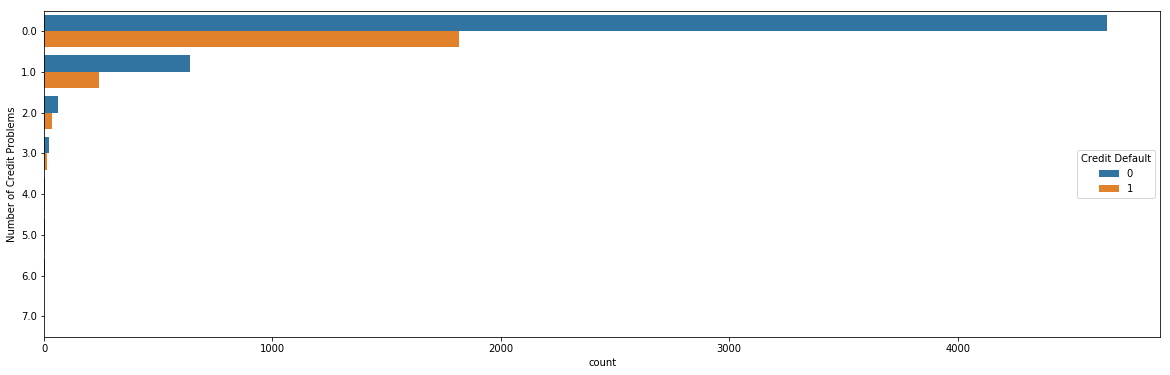

In [0]:
research_feature('Number of Credit Problems')

In [0]:
old_col = 'Number of Credit Problems'
new_col = 'New Credit Problems'
dict_replace = dict(zip(['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0'], [0, 0, 1, 2, 3, 3, 4, 4]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 2 1 4 3]
[0 3 1 2 4 '15.0']


In [0]:
df_valid.loc[df_valid[old_col] == '15.0']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,ID,Credit ownership,Years job experiance,New Tax Liens,New Credit Problems
2282,Own Home,1410294.0,10+ years,15.0,5.0,20.1,478984.0,15.0,42.0,0.0,debt consolidation,Short Term,447392.0,301549.0,15513.0,746.0,9782,0,2,1,15.0


In [0]:
df_valid.loc[df_valid[old_col] == '15.0', new_col] = 3
df_valid[new_col].unique()

array([0, 3, 1, 2, 4])

#### **Bankruptcies**

Credit Default Bankruptcies     0     1    Mean 1
0                       0.0  4782  1878  0.281982
1                       1.0   569   217  0.276081
2                       2.0    20    11  0.354839
3                       3.0     5     2  0.285714
4                       4.0     1     1  0.500000
5                       nan    10     4  0.285714


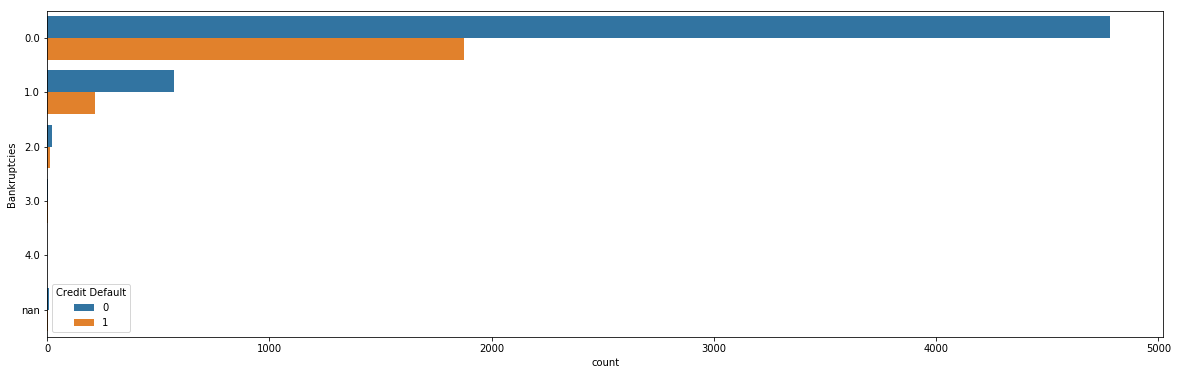

In [0]:
research_feature('Bankruptcies')

In [0]:
old_col = 'Bankruptcies'
new_col = 'New Bankruptcies'
dict_replace = dict(zip(['0.0', '1.0', '2.0', '3.0', '4.0', 'nan'], [0, 0, 1, 0, 2, 0]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 1 2]
[0 '5.0' 1 2]


In [0]:
df_valid.loc[df_valid[old_col] == '5.0']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,ID,Credit ownership,Years job experiance,New Tax Liens,New Credit Problems,New Bankruptcies
95,Home Mortgage,2560915.0,7 years,0.0,10.0,37.5,109868.0,5.0,31.0,5.0,debt consolidation,Long Term,601656.0,7581.0,55273.0,692.0,7595,1,1,0,3,5.0
1790,Home Mortgage,537605.0,2 years,0.0,8.0,16.6,381898.0,5.0,32.0,5.0,home improvements,Long Term,214654.0,195586.0,15322.0,6700.0,9290,1,1,0,3,5.0


In [0]:
df_valid.loc[df_valid[old_col] == '5.0', new_col] = 0
df_valid[new_col].unique()

array([0, 1, 2])

#### **Purpose**

Credit Default               Purpose       0       1    Mean 1
0                      business loan    74.0    55.0  0.426357
1                          buy a car    72.0    24.0  0.250000
2                          buy house    25.0     9.0  0.264706
3                 debt consolidation  4290.0  1654.0  0.278264
4               educational expenses     9.0     1.0  0.100000
5                  home improvements   304.0   108.0  0.262136
6                     major purchase    31.0     9.0  0.225000
7                      medical bills    49.0    22.0  0.309859
8                             moving     9.0     2.0  0.181818
9                              other   468.0   197.0  0.296241
10                  renewable energy     NaN     2.0       NaN
11                    small business    12.0    14.0  0.538462
12                       take a trip    27.0    10.0  0.270270
13                          vacation     6.0     2.0  0.250000
14                           wedding    11.0     4.0  0

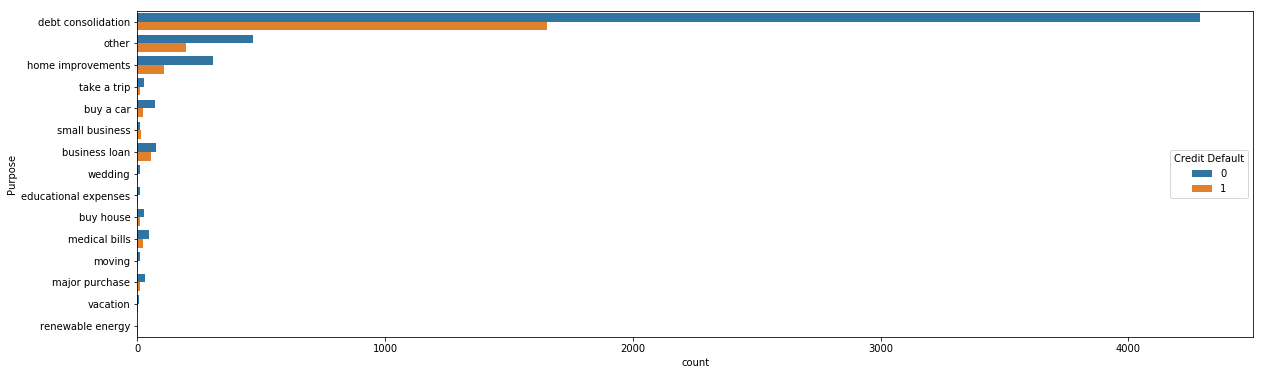

In [0]:
research_feature('Purpose')

In [0]:
old_col = 'Purpose'
new_col = 'New Purpose'
dict_replace = dict(zip(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], [0, 1, 2, 3, 2, 4, 4, 3, 5, 2, 1, 3, 2, 3, 0]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 1 2 3 4 5]
[0 5 2 1 4 3]


#### **Term**

Credit Default        Term     0     1    Mean 1
0                Long Term  1128   816  0.419753
1               Short Term  4259  1297  0.233441


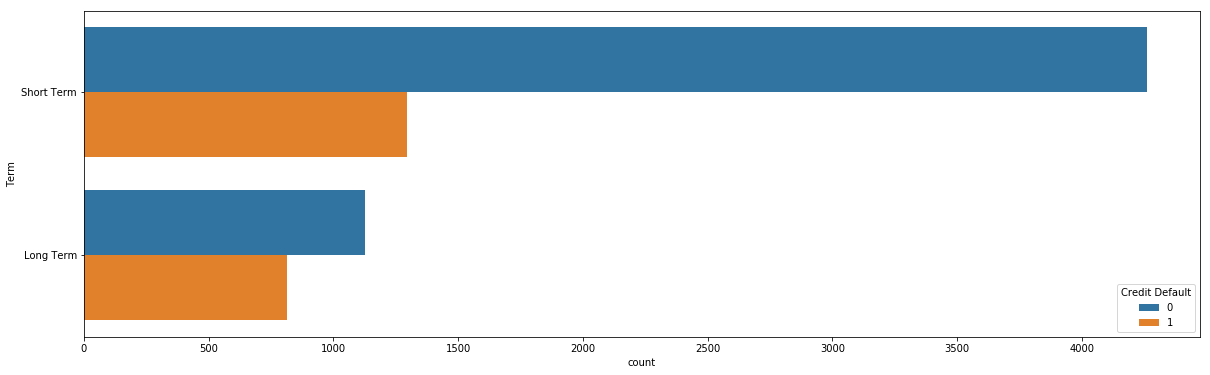

In [0]:
research_feature('Term')

In [0]:
old_col = 'Term'
new_col = 'New Term'
dict_replace = dict(zip(['Short Term', 'Long Term'], [0, 1]))

for frame in frames:
  frame[new_col] = frame.replace(dict_replace)[old_col]
  print(frame[new_col].unique())
  
NEW_FEATURES.append(new_col)

[0 1]
[0 1]


In [0]:
NEW_FEATURES

['Credit ownership',
 'Years job experiance',
 'New Tax Liens',
 'New Credit Problems',
 'New Bankruptcies',
 'New Purpose',
 'New Term']

In [0]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Credit ownership,Years job experiance,New Tax Liens,New Credit Problems,New Bankruptcies,New Purpose,New Term
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,2,0,0,0,0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,1,1,0,0,0,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3,0,1,0,0,0,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4,0,1,0,0,0,0,0


### **Числовые признаки**

In [0]:
NUM_COLS = df_info['Features'].loc[df_info['Type'] == 'float64'].to_list()
NUM_COLS

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [0]:
df.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID,Credit ownership,Years job experiance,New Tax Liens,New Credit Problems,New Bankruptcies,New Purpose,New Term
count,5.943000e+03,7500.000000,7500.000000,7.500000e+03,3419.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.366392e+06,11.130933,18.317467,9.451537e+05,34.692600,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733,3749.500000,0.486533,1.296000,0.007200,0.030800,0.004667,0.371067,0.259200
std,8.453392e+05,4.908924,7.041946,1.602622e+07,21.688806,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874,2165.207842,0.499852,0.554399,0.089158,0.244934,0.071965,0.848610,0.438225
min,1.645970e+05,2.000000,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.443410e+05,8.000000,13.500000,2.792295e+05,16.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000,1874.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,10.000000,17.000000,4.781590e+05,32.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,3749.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.640137e+06,14.000000,21.800000,7.935015e+05,50.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000,5624.250000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.014934e+07,43.000000,57.700000,1.304726e+09,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,7499.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000,1.000000


#### **Обработка пропусков**

In [0]:
df_info = info_table(df)
null_info_train = df_info.loc[df_info['Null'] > 0]
null_info_train

,Features,Null,Type,Unique
1,Annual Income,1557,float64,5479
8,Months since last delinquent,4081,float64,90
15,Credit Score,1557,float64,269


In [0]:
df_info = info_table(df_valid)
null_info_valid = df_info.loc[df_info['Null'] > 0]
null_info_valid

,Features,Null,Type,Unique
1,Annual Income,513,float64,1930
8,Months since last delinquent,1358,float64,84
15,Credit Score,513,float64,212


In [0]:
annual_ownership = df[['Annual Income', 'Home Ownership']].groupby(by='Home Ownership', as_index=False).median()
annual_ownership

,Home Ownership,Annual Income
0,Have Mortgage,1112013.0
1,Home Mortgage,1370869.0
2,Own Home,961590.0
3,Rent,1010724.0


In [0]:
for frame in frames:
  for i in annual_ownership.values:
    frame.loc[frame['Home Ownership'] == i[0], 'Annual Income'] = frame.loc[frame['Home Ownership'] == i[0], 'Annual Income'].fillna(i[1])

  print(frame.loc[frame['Annual Income'].isnull()].shape)

(0, 25)
(0, 24)


In [0]:
for frame in frames:
  frame.loc[frame['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
  print(frame.loc[frame['Months since last delinquent'].isnull()].shape)

(0, 25)
(0, 24)


In [0]:
for frame in frames:
  frame.loc[frame['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
  print(frame.loc[frame['Credit Score'].isnull()].shape)

(0, 25)
(0, 24)


In [0]:
df_newfeatures = info_table(df[NEW_FEATURES])
for_dummy_col = df_newfeatures.loc[df_newfeatures['Unique'] > 2, 'Features'].to_list()
DUMMY_FEATURES = df_newfeatures.loc[df_newfeatures['Unique'] == 2, 'Features'].to_list()
for_dummy_col

['Years job experiance',
 'New Tax Liens',
 'New Credit Problems',
 'New Bankruptcies',
 'New Purpose']

### **Dummy**

In [0]:
for cat_colname in for_dummy_col:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'ID', 'Credit ownership',
       'Years job experiance', 'New Tax Liens', 'New Credit Problems',
       'New Bankruptcies', 'New Purpose', 'New Term', 'Years job experiance_0',
       'Years job experiance_1', 'Years job experiance_2', 'New Tax Liens_0',
       'New Tax Liens_1', 'New Tax Liens_2', 'New Credit Problems_0',
       'New Credit Problems_1', 'New Credit Problems_2',
       'New Credit Problems_3', 'New Credit Problems_4', 'New Bankruptcies_0',
       'New Bankruptcies_1', 'New Bankruptcies_2', 'New Purpose_0',
       'New Purpose_1', 'New Purpose_2', 'New Purpose_3', 'New Purpose_4',
       'Ne

In [0]:
for cat_colname in for_dummy_col:
    df_valid = pd.concat([df_valid, pd.get_dummies(df_valid[cat_colname], prefix=cat_colname)], axis=1)

df_valid.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'ID', 'Credit ownership', 'Years job experiance',
       'New Tax Liens', 'New Credit Problems', 'New Bankruptcies',
       'New Purpose', 'New Term', 'Years job experiance_0',
       'Years job experiance_1', 'Years job experiance_2', 'New Tax Liens_0',
       'New Tax Liens_1', 'New Tax Liens_2', 'New Credit Problems_0',
       'New Credit Problems_1', 'New Credit Problems_2',
       'New Credit Problems_3', 'New Credit Problems_4', 'New Bankruptcies_0',
       'New Bankruptcies_1', 'New Bankruptcies_2', 'New Purpose_0',
       'New Purpose_1', 'New Purpose_2', 'New Purpose_3', 'New Purpose_4',
       'New Purpose_5'],
   

In [0]:
df_info = info_table(df)
DUMMY_FEATURES += df_info.loc[df_info['Type'] == 'uint8', 'Features'].to_list()
DUMMY_FEATURES

['Credit ownership',
 'New Term',
 'Years job experiance_0',
 'Years job experiance_1',
 'Years job experiance_2',
 'New Tax Liens_0',
 'New Tax Liens_1',
 'New Tax Liens_2',
 'New Credit Problems_0',
 'New Credit Problems_1',
 'New Credit Problems_2',
 'New Credit Problems_3',
 'New Credit Problems_4',
 'New Bankruptcies_0',
 'New Bankruptcies_1',
 'New Bankruptcies_2',
 'New Purpose_0',
 'New Purpose_1',
 'New Purpose_2',
 'New Purpose_3',
 'New Purpose_4',
 'New Purpose_5']

In [0]:
df['Credit state'] = df['Current Loan Amount'] - df['Current Credit Balance']
df_valid['Credit state'] = df_valid['Current Loan Amount'] - df_valid['Current Credit Balance']

In [0]:
NUM_COLS.remove('Current Loan Amount')
NUM_COLS.remove('Current Credit Balance')
NUM_COLS.append('Credit state')

In [0]:
NUM_COLS

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Monthly Debt',
 'Credit Score',
 'Credit state']

In [0]:
df_train_allfeat = df.copy()
df_valid_allfeat = df_valid.copy()

In [0]:
SELECTED_FEATURES = DUMMY_FEATURES + NUM_COLS
SELECTED_FEATURES

['Credit ownership',
 'New Term',
 'Years job experiance_0',
 'Years job experiance_1',
 'Years job experiance_2',
 'New Tax Liens_0',
 'New Tax Liens_1',
 'New Tax Liens_2',
 'New Credit Problems_0',
 'New Credit Problems_1',
 'New Credit Problems_2',
 'New Credit Problems_3',
 'New Credit Problems_4',
 'New Bankruptcies_0',
 'New Bankruptcies_1',
 'New Bankruptcies_2',
 'New Purpose_0',
 'New Purpose_1',
 'New Purpose_2',
 'New Purpose_3',
 'New Purpose_4',
 'New Purpose_5',
 'Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Monthly Debt',
 'Credit Score',
 'Credit state']

## ПОдготовка  к обучению

### **Нормализация данных**

In [0]:
scaler = StandardScaler()

df[NUM_COLS] = scaler.fit_transform(df[NUM_COLS])
df_valid[NUM_COLS] = scaler.transform(df_valid[NUM_COLS])

In [0]:
X = df[SELECTED_FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=121)

frames = [X_train, X_test, df_valid]

#### **Устранение дисбаланса**

In [0]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()

0    3775
1    2950
Name: Credit Default, dtype: int64

In [0]:
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]

#### **Подбор гиперпараметров**

In [0]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10, 12, 15],
          'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2]}

In [0]:
models = {'LGBM': lgbm.LGBMClassifier(random_state=21)}
for name, model in models.items():
  find_parametrs(name, model, params)

LGBM: max score - 0.8069416571343286, best parametrs - {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.2}


In [0]:
model_lgbm = lgbm.LGBMClassifier(random_state=21, n_estimators=100, max_depth=5, learning_rate=0.2, reg_alpha=15)
model_lgbm.fit(X_train, y_train)

y_train_pred_lgbm = model_lgbm.predict(X_train)
y_test_pred_lgbm = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred_lgbm, y_test, y_test_pred_lgbm)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      3775
           1       0.77      0.62      0.69      2950

    accuracy                           0.75      6725
   macro avg       0.76      0.74      0.74      6725
weighted avg       0.76      0.75      0.75      6725

TEST

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1612
           1       0.59      0.53      0.56       638

    accuracy                           0.76      2250
   macro avg       0.70      0.69      0.70      2250
weighted avg       0.75      0.76      0.76      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1375  237
1                300  338


## Итоговые данные

In [0]:
x_valid = df_valid[SELECTED_FEATURES]

In [0]:
y_valid_pred = model_lgbm.predict(x_valid).astype('int32')
y_valid_pred

array([1, 0, 1, ..., 0, 0, 1], dtype=int32)

In [0]:
test_out = pd.DataFrame({'Id': df_valid['ID'], 'Credit Default':  y_valid_pred})
test_out.head()

,Id,Credit Default
0,7500,1
1,7501,0
2,7502,1
3,7503,0
4,7504,0


In [0]:
test_out.to_csv(PATH + '/FrantsuzovDS__predictions.csv', index=False)

#### Загрузка на Kaggle

In [0]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"francuzovd","key":"a67ee0ba80408d0435be9bd617d8bdba"}'}

In [0]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
os.listdir('/root/.kaggle/')

mkdir: cannot create directory ‘/root/.kaggle’: File exists


['kaggle.json']

In [0]:
!kaggle competitions submit -c credit-default-prediction-ai-big-data -f '/content/drive/My Drive/GeekBrains/Python для Data Science 2/Курсовая/FrantsuzovDS__predictions.csv' -m 'Final'

100% 17.1k/17.1k [00:00<00:00, 66.4kB/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (3.1 hours from now).
